In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from skimage.transform import resize

from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.opflow import StateFn, Gradient, I, Z
from qiskit.utils import QuantumInstance

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

In [2]:
qasm_sim = Aer.get_backend('qasm_simulator')
qinst = QuantumInstance(qasm_sim, 2048)

In [3]:
fn = 'data_banknote_authentication.txt'
data = np.loadtxt(fn,dtype=float,delimiter=',')
x = data[:,:-1]
y = data[:,-1]
# We keep only a certain number of datapoints for each label
class_size = 100
x0 = x[data[:,-1] == 0][:class_size:]
x1 = x[data[:,-1] == 1][:class_size:]
labels = np.array([0]*class_size + [1]*class_size)
test_ratio= 0.2
seed = 3897
x_train, x_test, y_train, y_test = train_test_split(np.concatenate((x0, x1), axis=0), labels, test_size=test_ratio, random_state=seed, stratify=labels)

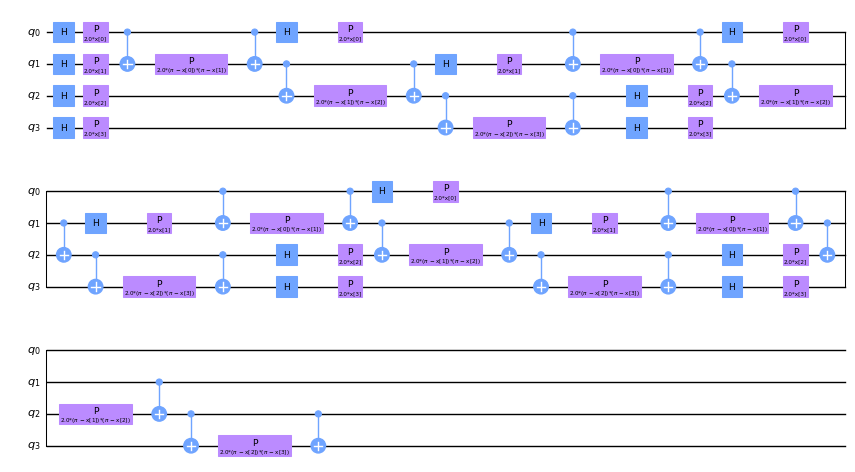

In [4]:
def get_zz_feature_map(feature_dim, feature_map_rep, ent):
    return ZZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)

fmap_zz = get_zz_feature_map(4, 4, 'linear')
fmap_zz.decompose().draw('mpl', scale=0.7)

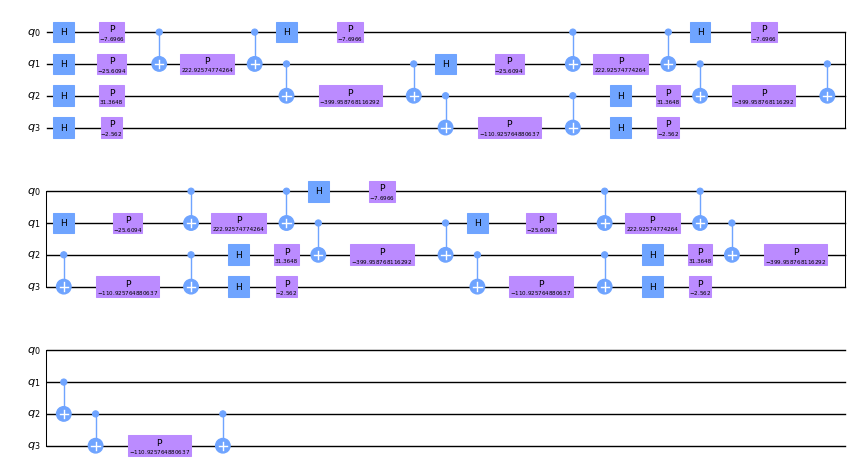

In [5]:
fmap_zz.assign_parameters({k:v for (k,v) in zip(fmap_zz.parameters, x_train[0])}).decompose().draw('mpl', scale=0.7)

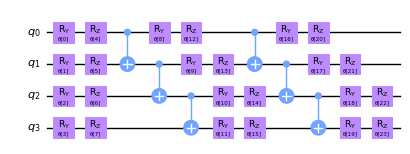

In [6]:
def get_two_locals(feature_dim, rotations, var_form_rep, ent):
    return TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)

ansatz_tl = get_two_locals(4, ['ry', 'rz'], 2, 'linear')
ansatz_tl.decompose().draw('mpl', scale=0.7)

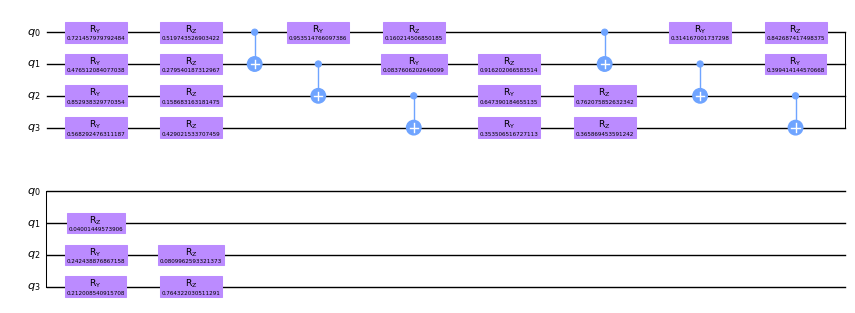

In [7]:
weights = np.random.random(len(ansatz_tl.parameters))
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}).decompose().draw('mpl', scale=0.7)

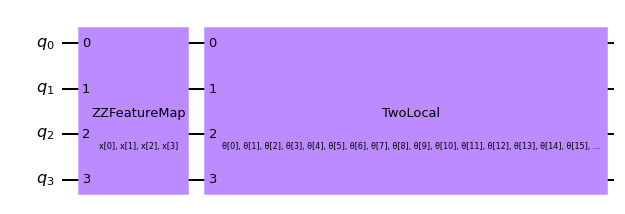

In [8]:
var_circuit = fmap_zz.compose(ansatz_tl)
var_circuit.draw('mpl')

In [9]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [10]:
num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap_zz.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz_tl.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [11]:
# The result of the neural network of the shape (output_shape).
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.5078125, 0.4921875]])

In [12]:
# The result of the neural network of the backward pass, i.e., a tuple with the gradients
# for input and weights of shape (output_shape, num_input) and
# (output_shape, num_weights), respectively.
_, update = qnn.backward(x_train[0], weights)
update

array([[[ 5.78613281e-02,  6.64062500e-02,  5.76171875e-02,
          2.44140625e-04,  6.27441406e-02,  4.15039062e-03,
          1.70898438e-02, -1.46484375e-03, -8.34960938e-02,
         -3.49121094e-02,  1.46484375e-03,  2.44140625e-03,
          4.51660156e-02, -4.90722656e-02, -1.22070312e-02,
         -8.30078125e-03, -2.45605469e-01, -2.44140625e-03,
         -2.44140625e-03,  3.90625000e-03, -1.46484375e-03,
         -3.17382812e-03, -1.85546875e-02,  7.32421875e-04],
        [-5.78613281e-02, -6.64062500e-02, -5.76171875e-02,
         -2.44140625e-04, -6.27441406e-02, -4.15039062e-03,
         -1.70898438e-02,  1.46484375e-03,  8.34960938e-02,
          3.49121094e-02, -1.46484375e-03, -2.44140625e-03,
         -4.51660156e-02,  4.90722656e-02,  1.22070312e-02,
          8.30078125e-03,  2.45605469e-01,  2.44140625e-03,
          2.44140625e-03, -3.90625000e-03,  1.46484375e-03,
          3.17382812e-03,  1.85546875e-02, -7.32421875e-04]]])

In [13]:
obs_parity = Z ^ 4
obs_one_qubit = I ^ (4 - 1) ^ Z
obs_one_qubit

PauliOp(Pauli('IIIZ'), coeff=1.0)

In [14]:
# For an introduction to the Opflow module, see
# https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/operators/01_operator_flow.ipynb
operator = ~StateFn(obs_one_qubit) @ StateFn(var_circuit)
operator

ComposedOp([OperatorStateFn(PauliOp(Pauli('IIIZ'), coeff=1.0), coeff=1.0, is_measurement=True), CircuitStateFn(<qiskit.circuit.library.data_preparation.zz_feature_map.ZZFeatureMap object at 0x000001A0FCF018E0>, coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False)

In [15]:
gradient = Gradient(grad_method="param_shift")
op_qnn = OpflowQNN(operator,
                   input_params=fmap_zz.parameters,
                   weight_params=ansatz_tl.parameters,
                   gradient=gradient,
                   quantum_instance=qinst)

In [16]:
output = op_qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 1)


array([[0.015625]])

In [17]:
_, update = op_qnn.backward(x_train[0], weights)
print(update.shape)
update

(1, 1, 24)


array([[[ 0.09082031,  0.11962891,  0.08251953,  0.00732422,
          0.12548828,  0.01806641,  0.01220703, -0.01074219,
         -0.1796875 , -0.01953125, -0.01269531, -0.01513672,
          0.11279297, -0.09375   ,  0.00195312,  0.00927734,
         -0.48730469, -0.01269531, -0.02734375,  0.01074219,
         -0.00195313, -0.00390625,  0.01269531,  0.00634766]]])

In [18]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [19]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [20]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


x_train_norm = np.array([x/np.linalg.norm(x) for x in x_train])

vqc = vqc.fit(x_train_norm, y_train_1h)

3 - 170.62567744061886
6 - 167.22700248401316
9 - 159.8096346919857
12 - 159.78510436712358
15 - 159.44039295422976
18 - 158.58271775384944
21 - 153.3347606199772
24 - 151.22043144428886
27 - 148.21602277600732
30 - 147.9828032174337
33 - 147.83419720743956
36 - 145.01801216522654
39 - 145.18431941324764
42 - 144.71483645299372
45 - 143.9744423191603
48 - 143.7264519587573
51 - 143.05664361650852
54 - 141.721213817315
57 - 141.9778404104286
60 - 142.16761327508502
63 - 141.8133621700212
66 - 141.12344140183237
69 - 141.5449500294629
72 - 141.23377193734433
75 - 141.1449033454187
78 - 141.22776839591293
81 - 141.12444860480514
84 - 140.99784789141142
87 - 140.667408777282
90 - 139.8895696709437
93 - 140.26131854570664
96 - 140.30538775691565
99 - 139.44110957506146
102 - 138.18906904166425
105 - 138.0166072898249
108 - 138.48184763232834
111 - 137.42944648260615
114 - 136.26937011833175
117 - 136.6231782120163
120 - 135.61079359835352
123 - 135.8140888375024
126 - 135.96726887425714
129

In [21]:
score_train = vqc.score(x_train, y_train_1h)
score_test = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

# for class_size = 24 (10 iterations) Score on the train set 0.47368421052631576
# Score on the test set 0.7
# for class size = 100 (50 iterations) Score on the train set 0.46875
#Score on the test set 0.475

Score on the train set 0.46875
Score on the test set 0.475
